In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import sqlite3
# import stats
from sklearn.cluster import KMeans

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

%load_ext sql
# %config InlineBackend.figure_formats = ['svg']
from IPython.display import display, Markdown

In [2]:
df = pd.read_csv('Collisions.csv', parse_dates=['INCDTTM'])
df.head(5)

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.263950,47.506127,2001,328656,330156,3857179,Unmatched,Block,NaN,S BANGOR ST BETWEEN 55TH AVE S AND 56TH AVE S,,NaN,2,Injury Collision,NaN,2,0,0,0,1,0,0,2020-02-08T00:00:00.000Z,2020-02-08,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y
1,-122.386116,47.561089,2002,328162,329662,3856099,Unmatched,Block,NaN,SW ALASKA ST BETWEEN 42ND AVE SW AND CALIFORNI...,,NaN,1,Property Damage Only Collision,NaN,2,0,0,0,0,0,0,2020-01-21T00:00:00.000Z,2020-01-21,Mid-Block (not related to intersection),16.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
2,-122.351134,47.570942,2003,327702,329202,3856190,Unmatched,Block,NaN,WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON...,,NaN,1,Property Damage Only Collision,NaN,1,0,0,0,0,0,0,2020-01-10T00:00:00.000Z,2020-01-10,Mid-Block (not related to intersection),26.0,MOTOR VEHICLE STRUCK OBJECT IN ROAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
3,-122.336648,47.613376,2004,328744,330244,EA13303,Unmatched,Block,NaN,6TH AVE BETWEEN OLIVE WAY AND STEWART ST,,NaN,1,Property Damage Only Collision,NaN,4,0,0,0,0,0,0,2020-02-06T00:00:00.000Z,2020-02-06,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y
4,-122.326715,47.661352,2005,328102,329602,EA06204,Unmatched,Block,NaN,NE 45TH ST BETWEEN 2ND AVE NE AND THACKERAY PL NE,,NaN,1,Property Damage Only Collision,NaN,3,0,0,0,0,0,0,2020-01-17T00:00:00.000Z,2020-01-17,Mid-Block (but intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N


# Re-labeling serverity

In [3]:
df['SEVERITYCODE'] = df['SEVERITYCODE'].map({'0': 'Unknown', '1': 'Prop_damage', '2': 'Injury', '2b': 'Serious_injury', '3': 'Fatality'})

In [3]:
df.groupby(['SEVERITYCODE']).size().to_frame('count')

,count
SEVERITYCODE,
0,21239
1,135545
2,57756
2b,3029
3,341


# Overview of the dataset

In [4]:
df.shape

(217911, 40)

In [5]:
df.dtypes

X                         float64
Y                         float64
OBJECTID                    int64
INCKEY                      int64
COLDETKEY                   int64
REPORTNO                   object
STATUS                     object
ADDRTYPE                   object
INTKEY                    float64
LOCATION                   object
EXCEPTRSNCODE              object
EXCEPTRSNDESC              object
SEVERITYCODE               object
SEVERITYDESC               object
COLLISIONTYPE              object
PERSONCOUNT                 int64
PEDCOUNT                    int64
PEDCYLCOUNT                 int64
VEHCOUNT                    int64
INJURIES                    int64
SERIOUSINJURIES             int64
FATALITIES                  int64
INCDATE                    object
INCDTTM            datetime64[ns]
JUNCTIONTYPE               object
SDOT_COLCODE              float64
SDOT_COLDESC               object
INATTENTIONIND             object
UNDERINFL                  object
WEATHER       

In [6]:
df.isnull().sum(axis = 0)

X                    7410
Y                    7410
OBJECTID                0
INCKEY                  0
COLDETKEY               0
REPORTNO                0
STATUS                  0
ADDRTYPE             3676
INTKEY             147290
LOCATION             4532
EXCEPTRSNCODE      120403
EXCEPTRSNDESC      206017
SEVERITYCODE            1
SEVERITYDESC            0
COLLISIONTYPE       26758
PERSONCOUNT             0
PEDCOUNT                0
PEDCYLCOUNT             0
VEHCOUNT                0
INJURIES                0
SERIOUSINJURIES         0
FATALITIES              0
INCDATE                 0
INCDTTM                 0
JUNCTIONTYPE        12037
SDOT_COLCODE            1
SDOT_COLDESC            1
INATTENTIONIND     187870
UNDERINFL           26738
WEATHER             26934
ROADCOND            26863
LIGHTCOND           27029
PEDROWNOTGRNT      212826
SDOTCOLNUM          90706
SPEEDING           208234
ST_COLCODE           9413
ST_COLDESC          26758
SEGLANEKEY              0
CROSSWALKKEY

# Take a look at some of the categorial columns

In [7]:
df['year'] = pd.DatetimeIndex(df.INCDTTM).year

In [8]:
yeardf = df.groupby('year').year.size().to_frame('INCKEY').reset_index()
yeardf = yeardf[yeardf.INCKEY > 1]
#I dropped year 2003 which only had 1 incident in the dataset
yeardf.head(20)

,year,INCKEY
1,2004,15457
2,2005,16016
3,2006,15794
4,2007,15082
5,2008,14139
6,2009,13275
7,2010,11958
8,2011,12416
9,2012,12732
10,2013,12757


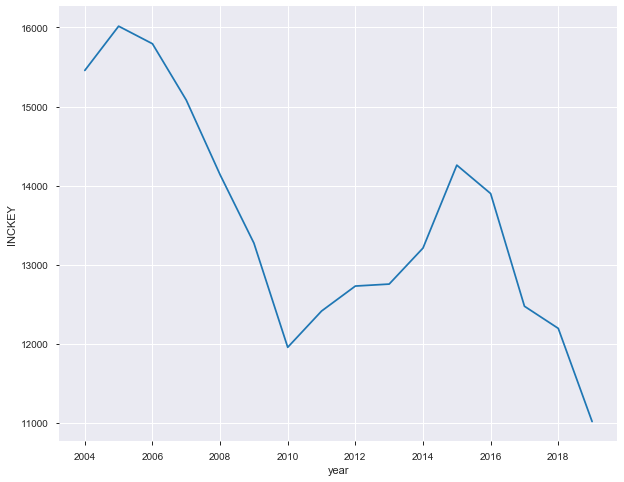

In [9]:
yeardf = yeardf[(yeardf['year'] < 2020)]
fig = plt.figure(figsize=(10, 8))
sns.lineplot(x="year", y="INCKEY", data=yeardf)


# External factors

In [10]:
df.groupby('LIGHTCOND').size().to_frame('OBJECTID').reset_index()

,LIGHTCOND,OBJECTID
0,Dark - No Street Lights,1535
1,Dark - Street Lights Off,1222
2,Dark - Street Lights On,48891
3,Dawn,2531
4,Daylight,117060
5,Dusk,5956
6,Other,236
7,Unknown,13451


In [11]:
df.groupby('WEATHER').size().to_frame('OBJECTID').reset_index()

,WEATHER,OBJECTID
0,Blowing Sand or Dirt or Snow,56
1,Clear or Partly Cloudy,112498
2,Fog/Smog/Smoke,574
3,Other,807
4,Overcast,27740
5,Raining,33153
6,Severe Crosswind,26
7,Sleet/Hail/Freezing Rain,110
8,Snowing,900
9,Unknown,15113


# People factors

In [12]:
people_factors = ['INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING']
for factor in people_factors:
  display(Markdown(f"### {factor}"))
  display(df.groupby(factor).size().to_frame('OBJECTID').reset_index())

### INATTENTIONIND

,INATTENTIONIND,OBJECTID
0,Y,30041


### UNDERINFL

,UNDERINFL,OBJECTID
0,0,81685
1,1,4231
2,N,99905
3,Y,5352


### PEDROWNOTGRNT

,PEDROWNOTGRNT,OBJECTID
0,Y,5085


### SPEEDING

,SPEEDING,OBJECTID
0,Y,9677


# Characteristics of the collision site

In [13]:
site_characteristics = ['ADDRTYPE', 'JUNCTIONTYPE', 'ROADCOND']
for characteristics in site_characteristics:
  display(Markdown(f"### {characteristics}"))
  display(df.groupby(characteristics).size().to_frame('OBJECTID').reset_index())

### ADDRTYPE

,ADDRTYPE,OBJECTID
0,Alley,856
1,Block,142758
2,Intersection,70621


### JUNCTIONTYPE

,JUNCTIONTYPE,OBJECTID
0,At Intersection (but not related to intersection),2492
1,At Intersection (intersection related),67919
2,Driveway Junction,11363
3,Mid-Block (but intersection related),24252
4,Mid-Block (not related to intersection),99639
5,Ramp Junction,190
6,Unknown,19


### ROADCOND

,ROADCOND,OBJECTID
0,Dry,125989
1,Ice,1215
2,Oil,64
3,Other,131
4,Sand/Mud/Dirt,75
5,Snow/Slush,1005
6,Standing Water,116
7,Unknown,15038
8,Wet,47415


# Outcome

In [14]:
sdot_coldesc = df.groupby('SDOT_COLDESC').size().to_frame('OBJECTID').reset_index()
sdot_coldesc.sort_values('OBJECTID', ascending=False, inplace=True)
sdot_coldesc

,SDOT_COLDESC,OBJECTID
14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",90298
17,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",58257
26,NOT ENOUGH INFORMATION / NOT APPLICABLE,19209
16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",10739
12,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,9412
10,MOTOR VEHCILE STRUCK PEDESTRIAN,7591
15,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",6844
20,MOTOR VEHICLE STRUCK OBJECT IN ROAD,4944
21,"MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END A...",3368
18,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE...",1773


In [15]:
outcome_info = [
  'PERSONCOUNT',
  'PEDCOUNT',
  'PEDCYLCOUNT',
  'VEHCOUNT',
  'INJURIES',
  'SERIOUSINJURIES',
  'FATALITIES'
]
outcome = df[df.columns.intersection(outcome_info)]
outcome.describe()

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES
count,217911.000000,217911.000000,217911.000000,217911.000000,217911.000000,217911.000000,217911.000000
mean,2.226129,0.037713,0.027204,1.722896,0.373607,0.015034,0.001666
std,1.473632,0.200821,0.164082,0.835058,0.732599,0.157780,0.044339
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000
max,93.000000,6.000000,2.000000,15.000000,78.000000,41.000000,5.000000


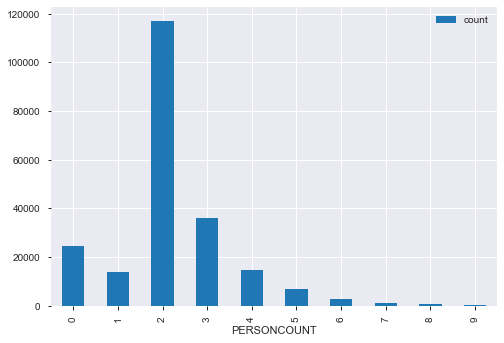

In [76]:
perdf = df[df.PERSONCOUNT < 10]
pergdf = perdf.groupby(perdf.PERSONCOUNT).size().to_frame('count')
pergdf.plot.bar()

{'whiskers': [<matplotlib.lines.Line2D at 0x15178add0>,
 'caps': [<matplotlib.lines.Line2D at 0x1517a6690>,
 'boxes': [<matplotlib.lines.Line2D at 0x1517a0110>],
 'medians': [<matplotlib.lines.Line2D at 0x14d09af10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1517ad610>],
 'means': []}

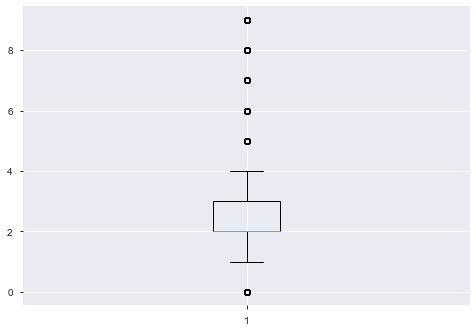

In [77]:
plt.boxplot(perdf.PERSONCOUNT)

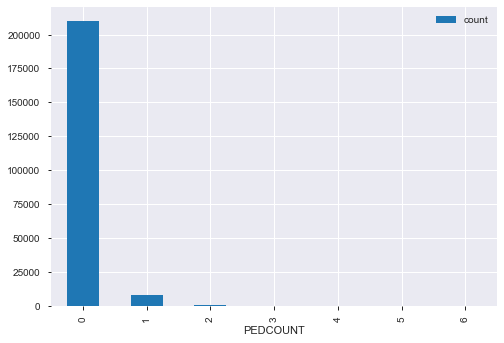

In [78]:
pedgdf = df.groupby(df.PEDCOUNT).size().to_frame('count')
pedgdf.plot.bar()

{'whiskers': [<matplotlib.lines.Line2D at 0x128e14810>,
 'caps': [<matplotlib.lines.Line2D at 0x128bddd10>,
 'boxes': [<matplotlib.lines.Line2D at 0x128e07b50>],
 'medians': [<matplotlib.lines.Line2D at 0x128e1bcd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x128e14dd0>],
 'means': []}

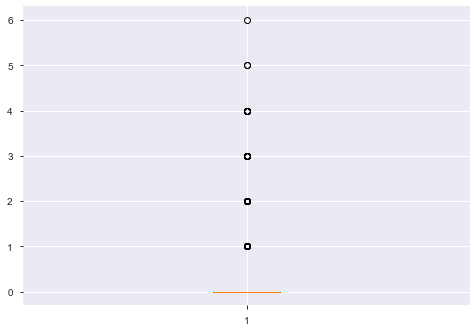

In [45]:
plt.boxplot(df.PEDCOUNT)

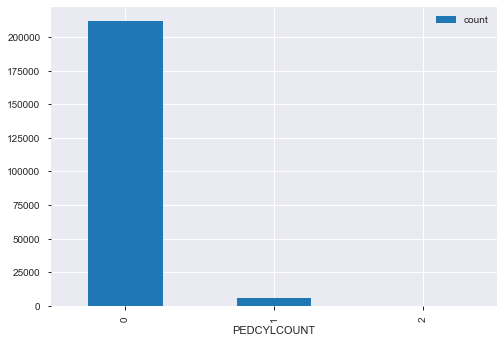

In [79]:
pedclgdf = df.groupby(df.PEDCYLCOUNT).size().to_frame('count')
pedclgdf.plot.bar()

{'whiskers': [<matplotlib.lines.Line2D at 0x12a3e43d0>,
 'caps': [<matplotlib.lines.Line2D at 0x12a3e4e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x12a359750>],
 'medians': [<matplotlib.lines.Line2D at 0x12a3eb890>],
 'fliers': [<matplotlib.lines.Line2D at 0x12a3ebd90>],
 'means': []}

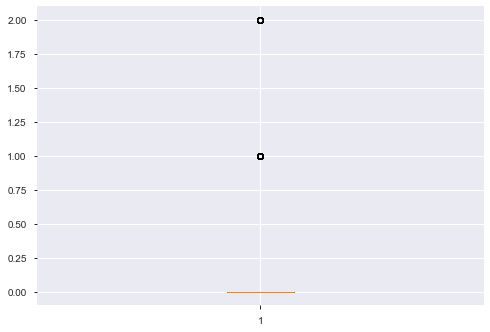

In [46]:
plt.boxplot(df.PEDCYLCOUNT)

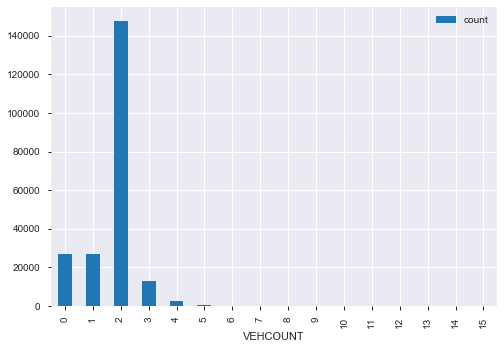

In [80]:
vehgdf = df.groupby(df.VEHCOUNT).size().to_frame('count')
vehgdf.plot.bar()

{'whiskers': [<matplotlib.lines.Line2D at 0x128f75f90>,
 'caps': [<matplotlib.lines.Line2D at 0x128f7da10>,
 'boxes': [<matplotlib.lines.Line2D at 0x128f75350>],
 'medians': [<matplotlib.lines.Line2D at 0x128f68250>],
 'fliers': [<matplotlib.lines.Line2D at 0x128f84990>],
 'means': []}

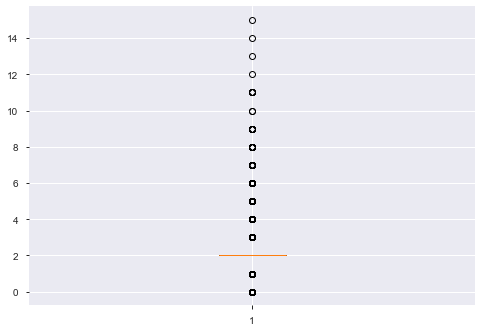

In [48]:
plt.boxplot(df.VEHCOUNT)

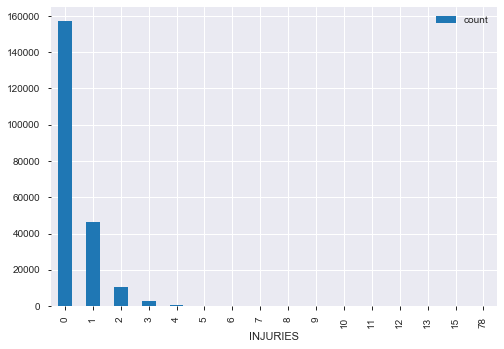

In [57]:
gdf = df.groupby(df.INJURIES).size().to_frame('count')
gdf.plot.bar()

{'whiskers': [<matplotlib.lines.Line2D at 0x13be63f90>,
 'caps': [<matplotlib.lines.Line2D at 0x13be630d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13be66310>],
 'medians': [<matplotlib.lines.Line2D at 0x13be61090>],
 'fliers': [<matplotlib.lines.Line2D at 0x13be608d0>],
 'means': []}

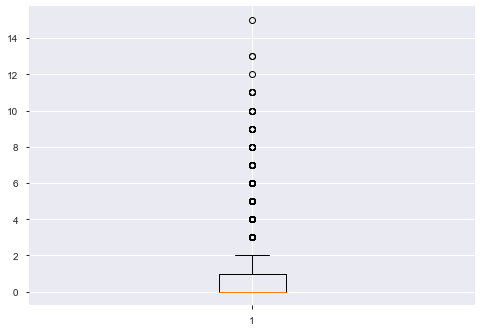

In [63]:
injdf = df[df.INJURIES < 70]
plt.boxplot(injdf.INJURIES)

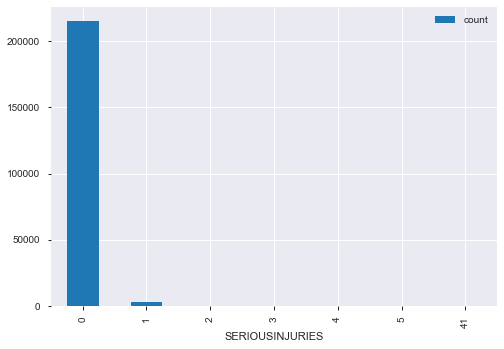

In [64]:
sidf = df.groupby(df.SERIOUSINJURIES).size().to_frame('count')
sidf.plot.bar()

{'whiskers': [<matplotlib.lines.Line2D at 0x12f4f2810>,
 'caps': [<matplotlib.lines.Line2D at 0x12f4e7bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f4e7b90>],
 'medians': [<matplotlib.lines.Line2D at 0x12f4f8cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f4f2dd0>],
 'means': []}

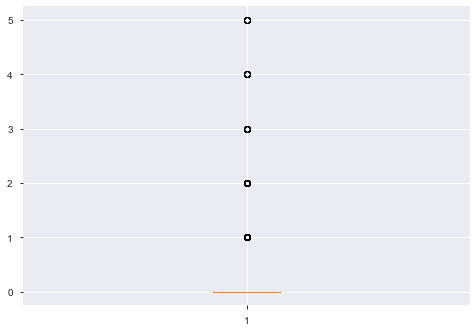

In [68]:
sinjdf = df[df.SERIOUSINJURIES < 40]
plt.boxplot(sinjdf.SERIOUSINJURIES)

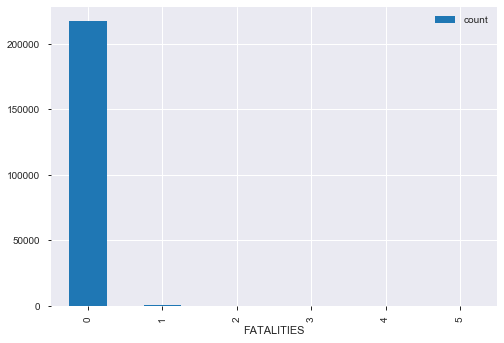

In [69]:
fdf = df.groupby(df.FATALITIES).size().to_frame('count')
fdf.plot.bar()

{'whiskers': [<matplotlib.lines.Line2D at 0x13ba460d0>,
 'caps': [<matplotlib.lines.Line2D at 0x13ba46a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x130bc1390>],
 'medians': [<matplotlib.lines.Line2D at 0x13ba4d510>],
 'fliers': [<matplotlib.lines.Line2D at 0x13ba4da10>],
 'means': []}

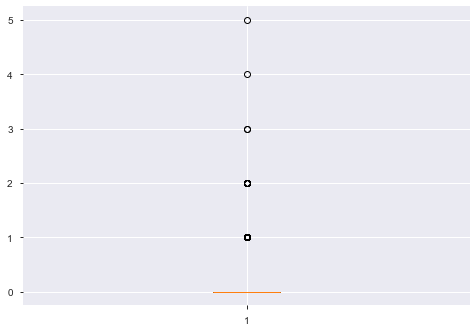

In [70]:
plt.boxplot(df.FATALITIES)

# Incidents by type of location

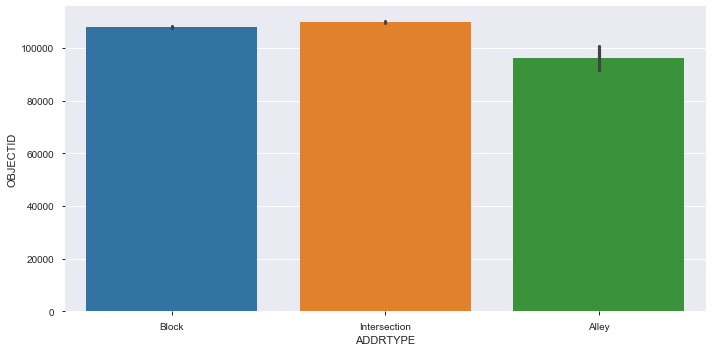

In [16]:
fig = plt.figure(figsize=(10, 5))

chart = sns.barplot(data= df, x= 'ADDRTYPE', y= 'OBJECTID')

plt.tight_layout()

# Incidents by type of collision

In [48]:
colldf = df.groupby('COLLISIONTYPE').size().to_frame('OBJECTID').reset_index()
colldf.head()

,COLLISIONTYPE,OBJECTID
0,Angles,34664
1,Cycles,5802
2,Head On,2122
3,Left Turn,13837
4,Other,24027


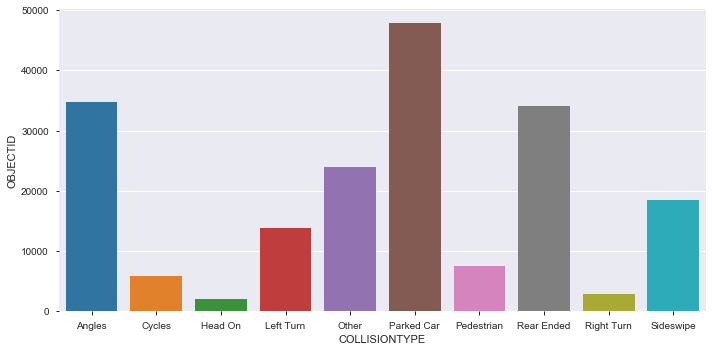

In [49]:
fig = plt.figure(figsize=(10, 5))

chart = sns.barplot(data= colldf, x= 'COLLISIONTYPE', y= 'OBJECTID')

plt.tight_layout()

# Incidents by severity

In [50]:
scdf = df.groupby('SEVERITYCODE').size().to_frame('OBJECTID').reset_index()
scdf.head()

,SEVERITYCODE,OBJECTID
0,Fatality,341
1,Injury,57756
2,Prop_damage,135545
3,Serious_injury,3029
4,Unknown,21239


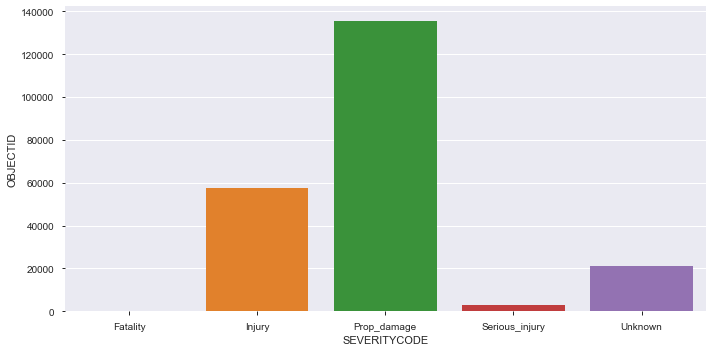

In [51]:
fig = plt.figure(figsize=(10, 5))

chart = sns.barplot(data= scdf, x= 'SEVERITYCODE', y= 'OBJECTID')

plt.tight_layout()

Note: SEVERITYCODE and SEVERITYDESC have the same information


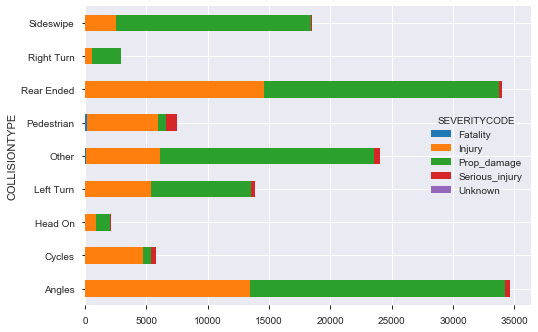

In [46]:
pivdf = df[(df['COLLISIONTYPE'] !='Parked Car')]
pivdf.pivot_table(index='COLLISIONTYPE', columns='SEVERITYCODE', aggfunc='size').plot.barh(stacked=True)

# Severity by type of collision

In [22]:
type_severity = df.groupby(['COLLISIONTYPE', 'SEVERITYCODE'])['INCKEY'].count().reset_index()
type_severity_pivot = type_severity.pivot(
    columns = 'SEVERITYCODE',
    index = 'COLLISIONTYPE',
    values = 'INCKEY').reset_index()
type_severity_pivot

SEVERITYCODE,COLLISIONTYPE,Fatality,Injury,Prop_damage,Serious_injury,Unknown
0,Angles,24.0,13453.0,20754.0,432.0,1.0
1,Cycles,25.0,4695.0,667.0,415.0,NaN
2,Head On,20.0,862.0,1139.0,101.0,NaN
3,Left Turn,16.0,5346.0,8207.0,268.0,NaN
4,Other,91.0,6047.0,17400.0,489.0,NaN
5,Parked Car,7.0,2629.0,45054.0,125.0,NaN
6,Pedestrian,125.0,5839.0,658.0,834.0,NaN
7,Rear Ended,11.0,14564.0,19202.0,222.0,NaN
8,Right Turn,1.0,602.0,2327.0,20.0,NaN
9,Sideswipe,10.0,2474.0,15926.0,71.0,NaN


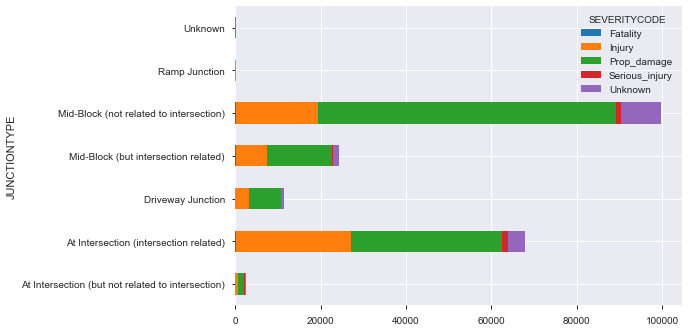

In [53]:
df.pivot_table(index='JUNCTIONTYPE', columns='SEVERITYCODE', aggfunc='size').plot.barh(stacked=True)

# Which locations have had high numbers of incidents?

In [23]:
locdf = df.groupby('LOCATION').size().to_frame('INCKEY').reset_index()
locdf.sort_values('INCKEY', ascending=False, inplace=True)
locdf.head(10)

,LOCATION,INCKEY
11241,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB ...,298
17512,N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND COR...,294
11242,BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ...,291
11075,AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST,278
9543,6TH AVE AND JAMES ST,270
11079,AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST,264
10774,ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ...,256
20135,RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLE...,254
10786,ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND...,230
24688,WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON...,224


In [47]:
locdf.shape

(25051, 2)

# Which locations have the highest numbers of fatal and serious injuries?

In [65]:
severity = ['Fatality', 'Serious_injury', 'Injury']
sevdf = df[(df['SEVERITYCODE'].isin(severity))]
sevcdf = sevdf.groupby('LOCATION').size().to_frame('INCKEY').reset_index()
sevcdf.sort_values('INCKEY', ascending=False, inplace=True)
sevcdf.head(10)

,LOCATION,INCKEY
5631,AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST,124
4697,6TH AVE AND JAMES ST,111
9263,N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND COR...,96
10378,RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLE...,96
5635,AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST,94
5764,BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ...,93
5763,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB ...,81
12522,WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON...,81
5450,ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND...,77
4454,5TH AVE AND SPRING ST,76


Note: Locations that have the highest numbers of incidents and locations that have more severe incidetns don't overlap a lot

In [66]:
sevcdf.shape

(12720, 2)

In [67]:
sevcdf.INCKEY.sum()

60845

In [71]:
sev_num = pd.merge(locdf, sevcdf, left_on = 'LOCATION', right_on = 'LOCATION')
sev_num.rename(columns = {'INCKEY_x': 'Total_incidents', 'INCKEY_y': 'Severe_incidents'}, inplace=True)
sev_num.head(10)

,LOCATION,Total_incidents,Severe_incidents
0,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB ...,298,81
1,N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND COR...,294,96
2,BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ...,291,93
3,AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST,278,124
4,6TH AVE AND JAMES ST,270,111
5,AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST,264,94
6,ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ...,256,68
7,RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLE...,254,96
8,ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND...,230,77
9,WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON...,224,81


In [72]:
sev_num.shape

(12720, 3)

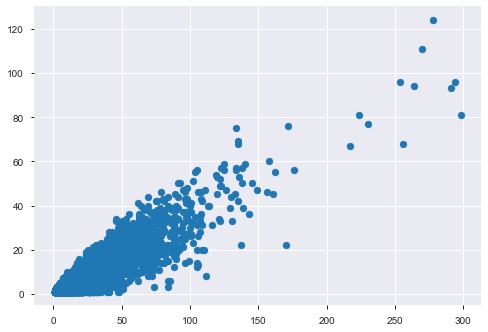

In [76]:
plt.scatter(x=sev_num['Total_incidents'], y=sev_num['Severe_incidents'])
plt.show()

# Notes

In [11]:
status = list(df['STATUS'].unique())
status

['Unmatched', 'Matched']

Note: Not sure what 'matched' means. Not in the dictionary.

In [21]:
df.ST_COLCODE.unique()

array([' ', nan, '13', '71', '32', '10', '14', '11', '23', '12', '45',
       '28', '52', '6', '0', '50', '20', '15', '51', '74', '16', '81',
       '2', '3', '26', '1', '40', '22', '19', '24', '30', '29', '25', '4',
       '5', '21', '57', '72', '83', '53', '66', '56', '27', '41', '73',
       '8', '17', '65', '82', '49', '67', '84', '31', '43', '42', '64',
       '48', '54', '60', '87', '7', '85', '88', '18'], dtype=object)

In [46]:
df.ST_COLDESC.unique()

array([nan,
       'From same direction - both going straight - both moving - rear-end',
       'Same direction -- both turning right -- both moving -- sideswipe',
       'One parked--one moving', 'Entering at angle',
       'From same direction - both going straight - one stopped - rear-end',
       'From same direction - both going straight - both moving - sideswipe',
       'From same direction - all others',
       'From same direction - both going straight - one stopped - sideswipe',
       'Vehicle - Pedalcyclist',
       'From opposite direction - one left turn - one straight',
       'Vehicle overturned', 'Pedalcyclist Strikes Moving Vehicle',
       'Vehicle going straight hits pedestrian', 'Fixed object',
       'One car leaving parked position',
       'From same direction - one left turn - one straight',
       'Other object',
       'Same direction -- both turning right -- one stopped -- rear end',
       'From same direction - one right turn - one straight',
       'Same 